In [1]:
#import libraries 
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns  # For better visualization of the confusion matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Load MNIST data
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Convert data to numpy arrays
X_train = train_dataset.data.numpy().reshape(-1, 28*28) / 255.0
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy().reshape(-1, 28*28) / 255.0
y_test = test_dataset.targets.numpy()

# Further split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 3902985.25it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1050813.63it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2079000.68it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4008949.66it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# Convert data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Scaling for RBM
scaler = MinMaxScaler()
X_train = torch.tensor(scaler.fit_transform(X_train.cpu()), dtype=torch.float32).to(device)
X_val = torch.tensor(scaler.transform(X_val.cpu()), dtype=torch.float32).to(device)
X_test = torch.tensor(scaler.transform(X_test.cpu()), dtype=torch.float32).to(device)


In [4]:
# Define RBM model
class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units, k=1):
        super(RBM, self).__init__()
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.k = k

        # Initialize weights
        self.W = nn.Parameter(torch.randn(hidden_units, visible_units) * 0.01)
        self.b = nn.Parameter(torch.zeros(visible_units))  # visible bias
        self.c = nn.Parameter(torch.zeros(hidden_units))   # hidden bias

    def sample_hidden(self, visible):
        h_prob = torch.sigmoid(torch.matmul(visible, self.W.t()) + self.c)
        return torch.bernoulli(h_prob), h_prob

    def sample_visible(self, hidden):
        v_prob = torch.sigmoid(torch.matmul(hidden, self.W) + self.b)
        return torch.bernoulli(v_prob), v_prob

    def forward(self, x):
        hidden, _ = self.sample_hidden(x)
        for _ in range(self.k):
            visible, _ = self.sample_visible(hidden)
            hidden, _ = self.sample_hidden(visible)
        return visible

    def free_energy(self, visible):
        v_term = torch.matmul(visible, self.b)
        h_term = torch.sum(torch.log(1 + torch.exp(torch.matmul(visible, self.W.t()) + self.c)), dim=1)
        return -v_term - h_term

In [5]:
# Define DBN model
class DBN(nn.Module):
    def __init__(self, layer_sizes, k=1):
        super(DBN, self).__init__()
        self.rbm_layers = nn.ModuleList([RBM(layer_sizes[i], layer_sizes[i+1], k) for i in range(len(layer_sizes)-1)])
        self.mlp_layer = nn.Linear(layer_sizes[-1], 10)  # 10 for MNIST classification

    def forward(self, x):
        for rbm in self.rbm_layers:
            _, x = rbm.sample_hidden(x)
        x = self.mlp_layer(x)
        return x

    def pretrain(self, X_train, batch_size=64, epochs=20):
        for idx, rbm in enumerate(self.rbm_layers):
            optimizer = optim.Adam(rbm.parameters(), lr=0.001)
            print(f"Pre-training RBM layer {idx+1}")
            for epoch in range(epochs):
                running_loss = 0
                for i in range(0, len(X_train), batch_size):
                    batch_x = X_train[i:i + batch_size]

                    # Forward pass and compute free energy loss
                    v_recon = rbm(batch_x)
                    loss = torch.mean(rbm.free_energy(batch_x) - rbm.free_energy(v_recon))

                    optimizer.zero_grad()
                    loss.backward(retain_graph=True)
                    optimizer.step()

                    running_loss += loss.item()

                print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(X_train):.4f}')

            # After training the RBM, pass data through the RBM to get hidden activations
            X_train, _ = rbm.sample_hidden(X_train)


In [6]:
# Train the DBN
def train_dbn(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=64):
    optimizer = optim.AdamW(model.parameters(), lr=0.00001, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    criterion = nn.CrossEntropyLoss()

    # Convert your data to a TensorDataset and DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        # Training loop
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation loop
        model.eval()
        total_val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = total_val_loss / len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Step the scheduler if validation loss plateaus
        scheduler.step(val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [7]:
# Plot training and validation loss/accuracy
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = len(train_losses)

    plt.figure(figsize=(14, 6))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.plot(range(epochs), val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label='Training Accuracy')
    plt.plot(range(epochs), val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:
# Dimensionality reduction function
def reduce_dimensionality(model, X_data):
    model.eval()
    with torch.no_grad():
        for rbm in model.rbm_layers:
            _, X_data = rbm.sample_hidden(X_data)
    return X_data

In [9]:
# Function to reconstruct image from reduced data
def reconstruct_image(model, reduced_data):
    model.eval()
    with torch.no_grad():
        visible, _ = model.rbm_layers[-1].sample_visible(reduced_data)
        for rbm in reversed(model.rbm_layers[:-1]):
            visible, _ = rbm.sample_visible(visible)
    return visible

In [10]:
# Visualization function
def visualize_reconstruction(original_data, reconstructed_data, n=10):
    fig, axes = plt.subplots(2, n, figsize=(12, 3))
    for i in range(n):
        axes[0, i].imshow(original_data[i].cpu().numpy().reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_data[i].cpu().numpy().reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    plt.show()


In [11]:
# Instantiate the DBN model
dbn_model = DBN([784, 500, 250, 100]).to(device)


In [12]:
# Pretrain the RBM layers
dbn_model.pretrain(X_train, epochs=20)


Pre-training RBM layer 1
Epoch [1/20], Loss: -0.2241
Epoch [2/20], Loss: -0.1632
Epoch [3/20], Loss: -0.1310
Epoch [4/20], Loss: -0.0997
Epoch [5/20], Loss: -0.0747
Epoch [6/20], Loss: -0.0567
Epoch [7/20], Loss: -0.0437
Epoch [8/20], Loss: -0.0336
Epoch [9/20], Loss: -0.0271
Epoch [10/20], Loss: -0.0215
Epoch [11/20], Loss: -0.0171
Epoch [12/20], Loss: -0.0135
Epoch [13/20], Loss: -0.0113
Epoch [14/20], Loss: -0.0089
Epoch [15/20], Loss: -0.0075
Epoch [16/20], Loss: -0.0049
Epoch [17/20], Loss: -0.0034
Epoch [18/20], Loss: -0.0024
Epoch [19/20], Loss: -0.0012
Epoch [20/20], Loss: -0.0010
Pre-training RBM layer 2
Epoch [1/20], Loss: -0.1675
Epoch [2/20], Loss: -0.1550
Epoch [3/20], Loss: -0.1394
Epoch [4/20], Loss: -0.1218
Epoch [5/20], Loss: -0.1071
Epoch [6/20], Loss: -0.0939
Epoch [7/20], Loss: -0.0823
Epoch [8/20], Loss: -0.0729
Epoch [9/20], Loss: -0.0660
Epoch [10/20], Loss: -0.0580
Epoch [11/20], Loss: -0.0521
Epoch [12/20], Loss: -0.0472
Epoch [19/20], Loss: -0.0254
Epoch [20/2

In [13]:
train_losses, val_losses, train_accuracies, val_accuracies = train_dbn(dbn_model, X_train, y_train, X_val, y_val, epochs=50)

Epoch [1/50], Loss: 2.2842, Val Loss: 2.2094, Val Acc: 18.57%
Epoch [2/50], Loss: 2.1428, Val Loss: 2.0713, Val Acc: 36.44%
Epoch [3/50], Loss: 2.0061, Val Loss: 1.9361, Val Acc: 50.93%
Epoch [4/50], Loss: 1.8719, Val Loss: 1.8028, Val Acc: 60.90%
Epoch [5/50], Loss: 1.7402, Val Loss: 1.6725, Val Acc: 67.89%
Epoch [6/50], Loss: 1.6125, Val Loss: 1.5475, Val Acc: 73.30%
Epoch [7/50], Loss: 1.4909, Val Loss: 1.4294, Val Acc: 76.64%
Epoch [8/50], Loss: 1.3766, Val Loss: 1.3191, Val Acc: 79.23%
Epoch [9/50], Loss: 1.2702, Val Loss: 1.2168, Val Acc: 81.03%
Epoch [10/50], Loss: 1.1717, Val Loss: 1.1225, Val Acc: 82.52%
Epoch [11/50], Loss: 1.0811, Val Loss: 1.0357, Val Acc: 83.61%
Epoch [12/50], Loss: 0.9979, Val Loss: 0.9563, Val Acc: 84.70%
Epoch [13/50], Loss: 0.9220, Val Loss: 0.8840, Val Acc: 85.67%
Epoch [14/50], Loss: 0.8529, Val Loss: 0.8185, Val Acc: 86.60%
Epoch [15/50], Loss: 0.7904, Val Loss: 0.7592, Val Acc: 87.29%
Epoch [16/50], Loss: 0.7340, Val Loss: 0.7058, Val Acc: 87.94%
E

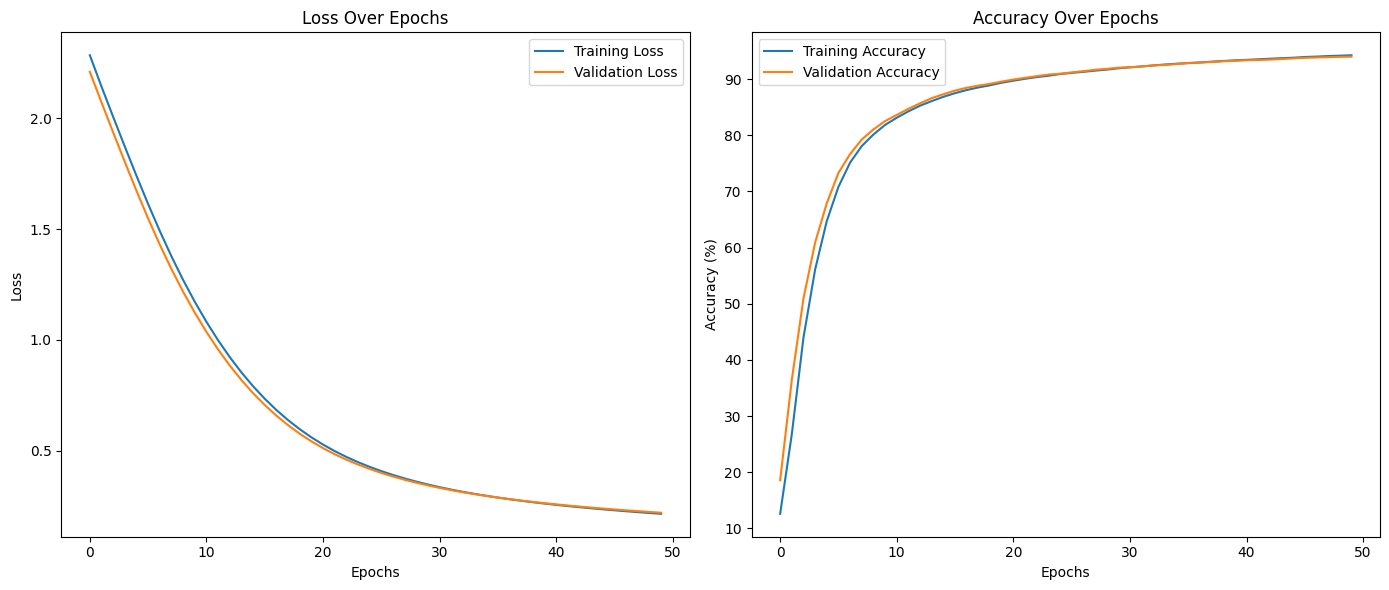

In [14]:
# Plot training/validation history
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [16]:
# Evaluate on test set
X_test_reduced = reduce_dimensionality(dbn_model, X_test)
y_pred = dbn_model.mlp_layer(X_test_reduced).argmax(dim=1).cpu().numpy()

# Display evaluation metrics
accuracy = accuracy_score(y_test.cpu(), y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test.cpu(), y_pred))

Test Accuracy: 94.41%
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.98      0.97      0.98      1135
           2       0.94      0.93      0.94      1032
           3       0.93      0.94      0.93      1010
           4       0.93      0.96      0.95       982
           5       0.93      0.92      0.93       892
           6       0.95      0.96      0.96       958
           7       0.95      0.93      0.94      1028
           8       0.93      0.93      0.93       974
           9       0.93      0.91      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



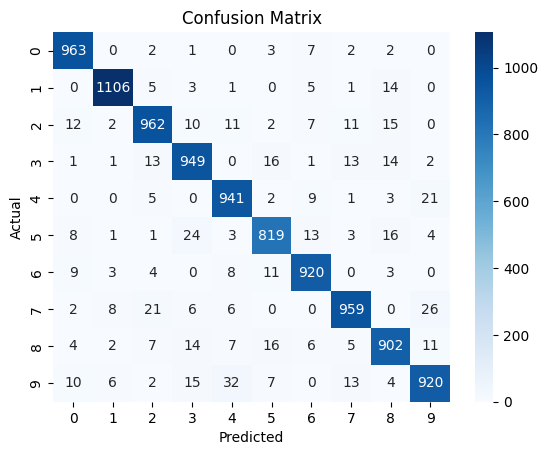

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test.cpu(), y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

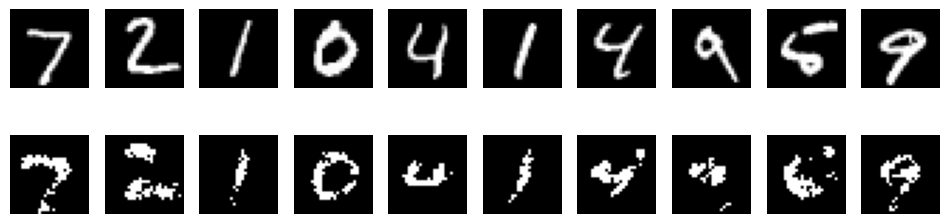

In [18]:
# Reconstruct images from reduced test set
reconstructed_images = reconstruct_image(dbn_model, X_test_reduced[:10])
visualize_reconstruction(X_test[:10], reconstructed_images)
